In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Word2Vec text processing
from gensim.models import Word2Vec

# For splitting data and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Enable inline plotting in notebooks
%matplotlib inline

In [13]:
# Load a subset of the ECG dataset from the online CSV (nrows=5000 for speed)
data_url = "https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv"
raw_table_data = pd.read_csv(data_url, nrows=5000)
print("Data loaded. Shape:", raw_table_data.shape)
raw_table_data.head(3)

Data loaded. Shape: (5000, 36)


,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77


In [14]:
# Remove outliers: keep rows where numeric features are all < 2000.
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 
                     'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]

# Ensure p_onset < p_end and qrs_onset < qrs_end.
full_df_filtered = full_df_filtered[
    (full_df_filtered['p_onset'] < full_df_filtered['p_end']) & 
    (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])
]

In [15]:
# Cell 4: Merge Text Reports and Adjust Column Names

# Merge the 18 report columns (report_0 to report_17) into one single report column.
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0']\
    .str.replace(r'\bnan\b', '', regex=True)\
    .str.replace(r'\s+', ' ', regex=True)\
    .str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)

# Drop the other report columns (report_1 to report_17)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Rename columns (remove trailing spaces from 'eeg_time ' and 'eeg_date ')
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

# Drop unnecessary columns: bandwidth and filtering
for col in ['bandwidth', 'filtering']:
    if col in full_df_filtered.columns:
        full_df_filtered = full_df_filtered.drop(columns=[col])

# Rearrange columns so that Healthy_Status is last
cols_order = [col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']
full_df_filtered = full_df_filtered[cols_order]


In [16]:
words = [text.split() for text in full_df_filtered['report']]

# Train a Word2Vec model on these tokens (min_count=1 ensures all words are included)
w2v_model = Word2Vec(words, min_count=1)

# Define a function to get the average embedding for a sentence.
def get_sentence_embedding(sentence):
    tokens = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Replace the textual report column by computing the mean embedding and then taking the mean of that vector.
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

# Display the head of the DataFrame after processing text
full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.011883,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.011883,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,0.035086,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.020614,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.020614,952,40,146,198,282,598,24,80,20,1


In [17]:
table_data = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
                               'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()
print("Prepared table_data shape:", table_data.shape)
table_data.head(3)

Prepared table_data shape: (3448, 10)


,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,0.011883,659,128,170,258,518,81,77,79,0
1,0.011883,722,124,162,246,504,77,75,70,0
2,0.035086,600,130,162,244,474,79,72,77,1


In [19]:
X = table_data.drop(columns=['Healthy_Status'])
y = table_data['Healthy_Status']

# Stratified train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (2413, 9)
Test set shape: (1035, 9)


In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ada', AdaBoostClassifier(algorithm='SAMME', random_state=42))
])

# Fit the pipeline on the training data.
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ada',
                 AdaBoostClassifier(algorithm='SAMME', random_state=42))])

In [21]:
# Cell 9: Evaluate the Model

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("AdaBoost Classifier Performance:")
print("Accuracy: {:.4f}".format(acc))
print("F1 Score: {:.4f}".format(f1))
print("AUC: {:.4f}".format(auc))
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:\n", report)


AdaBoost Classifier Performance:
Accuracy: 0.9816
F1 Score: 0.9664
AUC: 0.9980
Confusion Matrix:
[[743   4]
 [ 15 273]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       747
           1       0.99      0.95      0.97       288

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.98      1035
weighted avg       0.98      0.98      0.98      1035



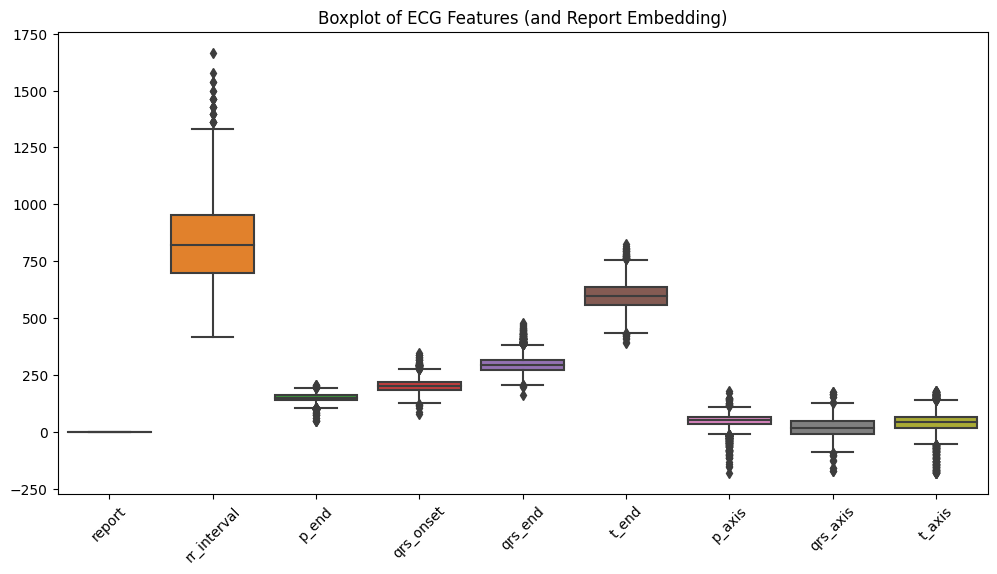

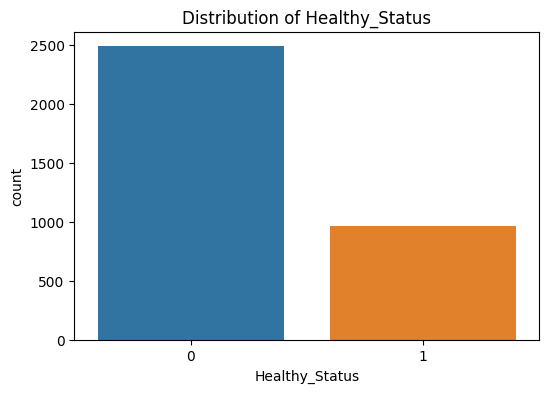

In [22]:
# Example: Boxplot for the distribution of features (excluding Healthy_Status)
plt.figure(figsize=(12, 6))
sns.boxplot(data=table_data.drop(columns=['Healthy_Status']))
plt.title("Boxplot of ECG Features (and Report Embedding)")
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of the target Healthy_Status
plt.figure(figsize=(6,4))
sns.countplot(x="Healthy_Status", data=table_data)
plt.title("Distribution of Healthy_Status")
plt.show()